In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
# fit a logistic regression model on an imbalanced classification dataset
from sklearn.metrics import r2_score, roc_auc_score, recall_score, precision_score, accuracy_score, mean_squared_error, auc, roc_curve
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats as st
from joblib import dump, load
import pickle
import csv
import random
from matplotlib.transforms import Affine2D
from imblearn.over_sampling import SMOTE, ADASYN
import dimod
import json
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from copy import deepcopy



In [23]:
df_all = pd.read_csv("data/med_orginal2.csv",header=0, sep="\,").fillna(method = "ffill")


target_f = 'Graft loss 1 year'

mandatory_f = [
    'AKI - KDIGO 2012',
    'FSGS',
    'Reduction to steroid only',
    'Transfusion [YES/NO]',
]

with open("data/16.json") as file:
    miqubo_result = dimod.SampleSet.from_serializable(json.load(file))
    miqubo_f = [x for x, y in miqubo_result.first.sample.items() if y ==1]

miqubo_f = list(set(miqubo_f) - set(mandatory_f) - set(target_f))
assert sum(df_all.isna().sum())==0, "Still nan entries in dataset"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [32]:
model_tmp = KNeighborsClassifier(6) #AdaBoostClassifier()

In [33]:
def train_on_k_features(model, df, target_f, mandatory_f, free_f, k, repetitions = 10, sample = True):
    print("aaaaa" + str(len(df.columns)))    
    threashold = 0.9
    df_ = deepcopy(df)
    y_train_pre = df.pop(target_f)

    # define evaluation procedure
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    results = {}
    results["roc"] = []
    results["recall"] = []
    results["precission"] = []
    results["accurarcy"] = []
    results["mse"] = []
    results["r2"] = []

    for i in range(repetitions):
        features = mandatory_f  + random.sample(set(free_f), k) #random.choices(free_f, k = k)
        #print(features)
        x_train, x_test, y_train, y_test = train_test_split(df_[features], y_train_pre, test_size=0.2, random_state=42, shuffle=True)
        # find out how cross_val_score works
        # scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        model_ = deepcopy(model)
        model_.fit(x_train, y_train)
        # discretize predictions
        y_pred = np.where(model_.predict(x_test)>threashold,1, 0)

        results["roc"].append(roc_auc_score(y_test, y_pred))
        results["recall"].append(recall_score(y_test, y_pred))
        results["precission"].append(precision_score(y_test, y_pred))
        results["accurarcy"].append(accuracy_score(y_test, y_pred))
        results["mse"].append(mean_squared_error(y_test, y_pred))
        results["r2"].append(r2_score(y_test, y_pred))

    stat_results = {}
    for key in results.keys():
        stat_results[key+"_mean"] = np.mean(results[key])
        stat_results[key+"_std"] = np.std(results[key])
    
    return stat_results

def train_on_range_features(model, df, target_f, mandatory_f, free_f, range, repetitions = 10, sample = True):
    df_ = deepcopy(df)
    n_f = 1 + len(mandatory_f)
    stat_res = {}

    naming_map = {x[1] : "f_{}".format(x[0]) for x in enumerate(df_.columns)}
    df_ = df_.rename(columns=naming_map)
    target_f_ = naming_map[target_f]
    mandatory_f_ = [naming_map[x] for x in mandatory_f]
    free_f_ = [naming_map[x] for x in free_f]
    if sample:
        y_train = df_.pop(target_f_)
        x_train = df_
        df_post_data, df_post_labels = SMOTE().fit_resample(x_train, y_train)
        df_post_data.insert(0, target_f_, df_post_labels)
    #print(type(df_post_data.copy()))
    #print(df_post_data.copy())
    for i in range:
        
        stat_res[n_f+i] = train_on_k_features(deepcopy(model), deepcopy(df_post_data), target_f_, mandatory_f_, free_f_, i, repetitions)

    return stat_res


In [1]:
model_tmp = LogisticRegression(solver='lbfgs')
model_1 = deepcopy(model_tmp)

all_remaining = list(set(df_all.columns) - set(mandatory_f) - set([target_f]))
all_stat = train_on_range_features(deepcopy(model_tmp), deepcopy(df_all), target_f, mandatory_f, all_remaining, np.arange(len(miqubo_f)), 5)

miqubo_df = deepcopy(df_all[[target_f] + mandatory_f + miqubo_f])
miqubo_stat = train_on_range_features(deepcopy(model_tmp), deepcopy(miqubo_df), target_f, mandatory_f, miqubo_f, np.arange(len(miqubo_f)), 5)

NameError: name 'LogisticRegression' is not defined

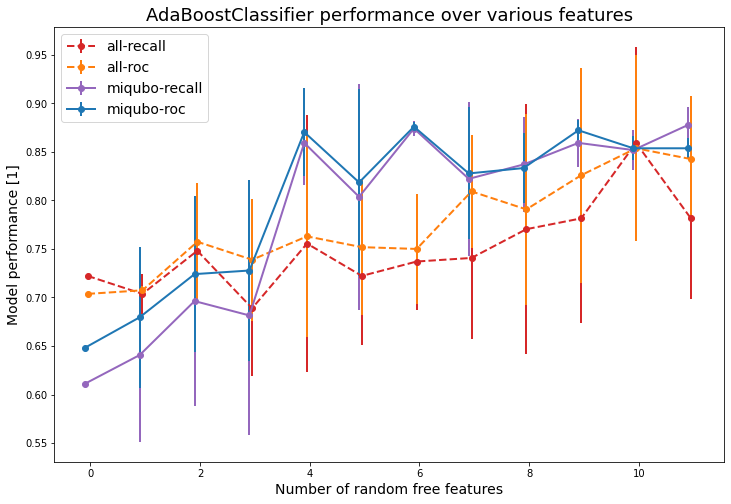

In [48]:
miqubo_series = {metric_key:[y[metric_key] for _, y in  miqubo_stat.items()] for metric_key in miqubo_stat[list(miqubo_stat.keys())[0]].keys()}
all_series = {metric_key:[y[metric_key] for _, y in  all_stat.items()] for metric_key in all_stat[list(all_stat.keys())[0]].keys()}

fig, ax = plt.subplots(figsize = (12,8))

trans1 = Affine2D().translate(-0.05, 0.0) + ax.transData
trans2 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans3 = Affine2D().translate(+0.05, 0.0) + ax.transData
trans4 = Affine2D().translate(+0.1, 0.0) + ax.transData

x_ = np.arange(len(miqubo_f))

ax.errorbar(
        x_, 
        all_series["recall_mean"], 
        yerr = all_series["recall_std"], 
        label = "all-recall",
        color='tab:red',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x_, 
        all_series["roc_mean"], 
        yerr = all_series["roc_std"], 
        label = "all-roc",
        color='tab:orange',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x_, 
        miqubo_series["recall_mean"], 
        yerr = miqubo_series["recall_std"], 
        label = "miqubo-recall",
        color='tab:purple',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '-')

ax.errorbar(
        x_, 
        miqubo_series["roc_mean"], 
        yerr = miqubo_series["roc_std"], 
        label = "miqubo-roc",
        color='tab:blue',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '-')

plt.legend(loc ='upper left', fontsize = 14)
 
plt.title('AdaBoostClassifier performance over various features',  fontsize = 18)
plt.xlabel('Number of random free features',  fontsize = 14)
plt.ylabel("Model performance [1]",  fontsize = 14)
#plt.savefig("plots/general/AdaBoost_performance_over_all_features.png")
plt.show()

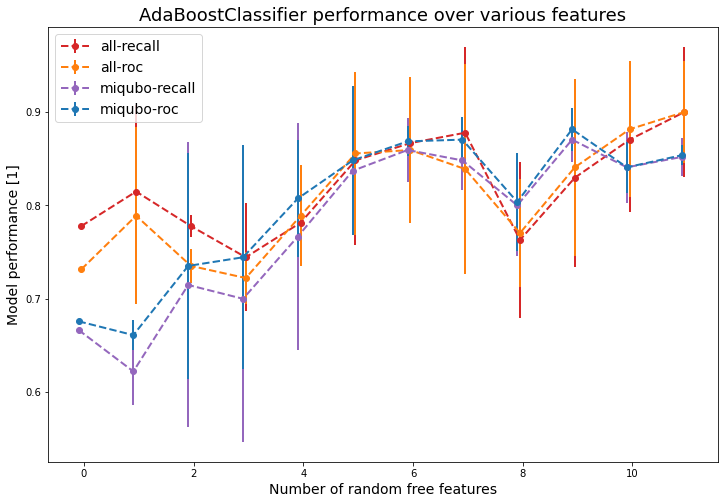

In [41]:
miqubo_series = {metric_key:[y[metric_key] for _, y in  miqubo_stat.items()] for metric_key in miqubo_stat[list(miqubo_stat.keys())[0]].keys()}
all_series = {metric_key:[y[metric_key] for _, y in  all_stat.items()] for metric_key in all_stat[list(all_stat.keys())[0]].keys()}

fig, ax = plt.subplots(figsize = (12,8))

trans1 = Affine2D().translate(-0.05, 0.0) + ax.transData
trans2 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans3 = Affine2D().translate(+0.05, 0.0) + ax.transData
trans4 = Affine2D().translate(+0.1, 0.0) + ax.transData

x = np.arange(len(miqubo_f))

ax.errorbar(
        x, 
        all_series["recall_mean"], 
        yerr = all_series["recall_std"], 
        label = "all-recall",
        color='tab:red',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x, 
        all_series["roc_mean"], 
        yerr = all_series["roc_std"], 
        label = "all-roc",
        color='tab:orange',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x, 
        miqubo_series["recall_mean"], 
        yerr = miqubo_series["recall_std"], 
        label = "miqubo-recall",
        color='tab:purple',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '--')

ax.errorbar(
        x, 
        miqubo_series["roc_mean"], 
        yerr = miqubo_series["roc_std"], 
        label = "miqubo-roc",
        color='tab:blue',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '--')

plt.legend(loc ='upper left', fontsize = 14)
 
plt.title('AdaBoostClassifier performance over various features',  fontsize = 18)
plt.xlabel('Number of random free features',  fontsize = 14)
plt.ylabel("Model performance [1]",  fontsize = 14)
#plt.savefig("plots/general/AdaBoost_performance_over_all_features.png")
plt.show()

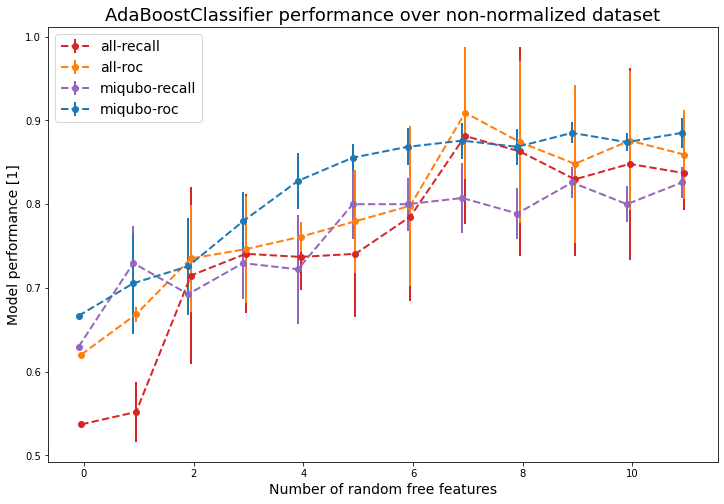

In [9]:
miqubo_series = {metric_key:[y[metric_key] for _, y in  miqubo_stat.items()] for metric_key in miqubo_stat[list(miqubo_stat.keys())[0]].keys()}
all_series = {metric_key:[y[metric_key] for _, y in  all_stat.items()] for metric_key in all_stat[list(all_stat.keys())[0]].keys()}

fig, ax = plt.subplots(figsize = (12,8))

trans1 = Affine2D().translate(-0.05, 0.0) + ax.transData
trans2 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans3 = Affine2D().translate(+0.05, 0.0) + ax.transData
trans4 = Affine2D().translate(+0.1, 0.0) + ax.transData

x = np.arange(len(miqubo_f))

ax.errorbar(
        x, 
        all_series["recall_mean"], 
        yerr = all_series["recall_std"], 
        label = "all-recall",
        color='tab:red',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x, 
        all_series["roc_mean"], 
        yerr = all_series["roc_std"], 
        label = "all-roc",
        color='tab:orange',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x, 
        miqubo_series["recall_mean"], 
        yerr = miqubo_series["recall_std"], 
        label = "miqubo-recall",
        color='tab:purple',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '--')

ax.errorbar(
        x, 
        miqubo_series["roc_mean"], 
        yerr = miqubo_series["roc_std"], 
        label = "miqubo-roc",
        color='tab:blue',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '--')

plt.legend(loc ='upper left', fontsize = 14)
 
plt.title('AdaBoostClassifier performance over non-normalized dataset',  fontsize = 18)
plt.xlabel('Number of random free features',  fontsize = 14)
plt.ylabel("Model performance [1]",  fontsize = 14)
#plt.savefig("plots/general/AdaBoost_performance_over_all_features.png")
plt.show()

In [33]:
binary_f = [x for x in df_all.columns if len(np.unique(df_all[x]))==2]
float_f = list(set([x for x, y in df_all.dtypes.items() if y == np.float]) - set(binary_f))
int_f = list(set([x for x, y in df_all.dtypes.items() if y == np.int]) - set(binary_f))

df_float_norm = pd.DataFrame(data=preprocessing.StandardScaler().fit(df_all[float_f]).transform(df_all[float_f]), columns=float_f)
df_int_norm = pd.DataFrame(data=preprocessing.StandardScaler().fit(df_all[int_f]).transform(df_all[int_f]), columns=int_f)
df_normalized = pd.concat([df_all[binary_f], df_float_norm, df_int_norm], axis=1, join="inner")


In [34]:
len(binary_f) + len(float_f) + len(int_f)

152

In [35]:
mandatory_f

['AKI - KDIGO 2012',
 'FSGS',
 'Reduction to steroid only',
 'Transfusion [YES/NO]']

In [36]:
miqubo_f_normalized = df_normalized[[target_f] + mandatory_f + miqubo_f]
miqubo_stat_n = train_on_range_features(deepcopy(model_tmp), miqubo_f_normalized, target_f, mandatory_f, miqubo_f, np.arange(len(miqubo_f)), 10)

all_remaining = list(set(df_normalized.columns) - set(mandatory_f) - set([target_f]))
all_stat_n = train_on_range_features(deepcopy(model_tmp), df_normalized, target_f, mandatory_f, all_remaining, np.arange(len(miqubo_f)), 10)


aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa17
aaaaa152
aaaaa152
aaaaa152
aaaaa152
aaaaa152
aaaaa152
aaaaa152
aaaaa152
aaaaa152
aaaaa152
aaaaa152
aaaaa152


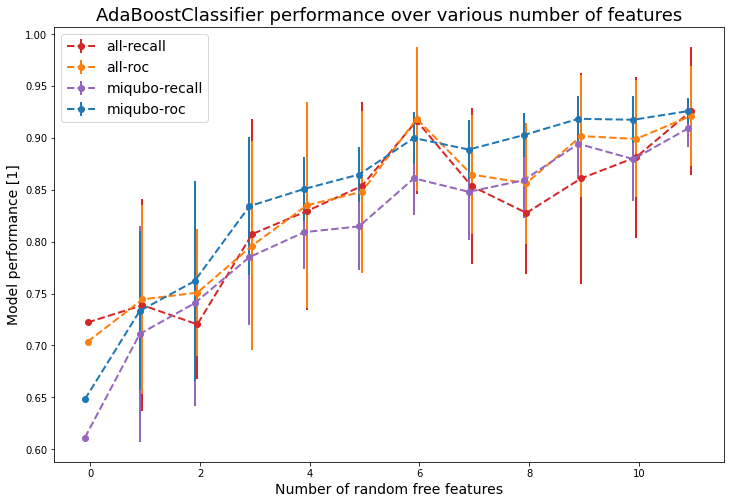

In [37]:
miqubo_series_n = {metric_key:[y[metric_key] for _, y in  miqubo_stat_n.items()] for metric_key in miqubo_stat_n[list(miqubo_stat_n.keys())[0]].keys()}
all_series_n = {metric_key:[y[metric_key] for _, y in  all_stat_n.items()] for metric_key in all_stat_n[list(all_stat_n.keys())[0]].keys()}

fig, ax = plt.subplots(figsize = (12,8))
trans1 = Affine2D().translate(-0.05, 0.0) + ax.transData
trans2 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans3 = Affine2D().translate(+0.05, 0.0) + ax.transData
trans4 = Affine2D().translate(+0.1, 0.0) + ax.transData

x = np.arange(len(miqubo_f))

ax.errorbar(
        x, 
        all_series_n["recall_mean"], 
        yerr = all_series_n["recall_std"], 
        label = "all-recall",
        color='tab:red',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x, 
        all_series_n["roc_mean"], 
        yerr = all_series_n["roc_std"], 
        label = "all-roc",
        color='tab:orange',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x, 
        miqubo_series_n["recall_mean"], 
        yerr = miqubo_series_n["recall_std"], 
        label = "miqubo-recall",
        color='tab:purple',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '--')

ax.errorbar(
        x, 
        miqubo_series_n["roc_mean"], 
        yerr = miqubo_series_n["roc_std"], 
        label = "miqubo-roc",
        color='tab:blue',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '--')

plt.legend(loc ='upper left', fontsize = 14)
 
plt.title('AdaBoostClassifier performance over various number of features',  fontsize = 18)
plt.xlabel('Number of random free features',  fontsize = 14)
plt.ylabel("Model performance [1]",  fontsize = 14)
#plt.savefig("plots/general/AdaBoost_performance_over_all_features.png")
plt.show()

In [20]:
df_normalized

,Confirmed UTI,Urinary sepsis,HTN,DM,PAD,CAD,ACS,HF,AF,Stroke/TIA,...,AKI KDIGO 2012 - Stage [1/2/3],ALAT [IU/l],Hight,Donor,Length of stay [days],ASPAT [IU/l],ilość UTI 2014-2019,GCS,HR,Charlston Comorbidity Index
0,1,1,1,0,0,0,0,0,0,0,...,2.626059,-0.696101,0.036175,0.0,-0.618020,-0.696955,-0.321858,-0.400355,-0.584436,-1.222226
1,1,1,1,1,1,1,1,0,0,0,...,1.528220,-0.654025,-0.502873,0.0,-0.489462,-0.669529,0.122542,-0.400355,-0.156716,1.394346
2,1,1,1,1,0,0,0,0,0,0,...,-0.667457,-0.654025,-1.796589,0.0,-0.746579,-0.669529,2.788946,-1.273593,-0.156716,-0.698912
3,1,1,1,0,0,0,0,0,0,0,...,0.430382,-0.680322,-0.718492,0.0,-0.296624,-0.706928,1.011344,-1.273593,-1.073259,0.347717
4,1,0,1,0,0,1,1,0,0,1,...,-0.667457,-0.696101,-1.365350,0.0,-0.682299,-0.507467,-0.321858,-0.400355,-1.378774,0.347717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,0,1,0,0,0,0,0,0,0,...,-0.667457,-0.769733,1.545510,0.0,-0.103786,-0.709422,-0.766259,0.472883,0.759828,-0.175597
297,0,0,1,0,0,0,0,0,0,0,...,-0.667457,-0.769733,-1.904398,0.0,-0.103786,-0.709422,-0.766259,0.472883,0.759828,-0.175597
298,0,0,1,1,0,1,0,0,1,0,...,-0.667457,-0.769733,1.868939,0.0,-0.103786,-0.709422,-0.766259,0.472883,0.759828,-0.175597
299,0,0,1,1,0,1,0,0,0,0,...,-0.667457,-0.769733,1.868939,0.0,-0.103786,-0.709422,-0.766259,0.472883,0.759828,-0.175597


In [123]:
df_all

,Age,Weight,Hight,BMI,Confirmed UTI,Urinary sepsis,Length of stay [days],HTN,DM,PAD,...,Graft loss 1 year,Graft loss observation 1 year,Another urosepsis 1 year,Another urosepsis 1 year - observation,AGR (acute graft rejection) - 1 year,AGR 1 year - observation [days],AGR in the past,Composite endpoint (DEATH / GRAFT LOSS/ ACUTE REJECTION,Composite endpoint - observation time [days],Composite endpoint (DEATH / GRAFT LOSS/ ACUTE REJECTION/ eGFR decline>20% to baseline
0,36,94.0,169,32.912013,1,1,9,1,0,0,...,0,365,0,365,0,365,0,0,365.0,0
1,55,68.0,164,25.282570,1,1,11,1,1,1,...,0,365,0,365,0,365,0,0,365.0,0
2,31,43.0,152,18.611496,1,1,7,1,1,0,...,0,365,0,365,0,365,0,0,365.0,1
3,72,60.5,162,23.052888,1,1,14,1,0,0,...,0,365,0,365,0,365,0,0,365.0,1
4,59,55.0,156,22.600263,1,0,8,1,0,0,...,0,365,0,365,0,365,0,0,365.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,58,84.0,183,25.082863,0,0,17,1,0,0,...,0,365,0,365,0,365,0,0,365.0,0
297,56,82.0,151,35.963335,0,0,17,1,0,0,...,0,365,0,365,0,365,0,0,365.0,0
298,51,52.0,186,29.772228,0,0,17,1,1,0,...,0,365,0,365,0,365,0,0,365.0,0
299,56,103.0,186,29.772228,0,0,17,1,1,0,...,1,334,0,365,0,365,0,1,334.0,1


In [126]:
set(df_normalized.columns) == set(df_all.columns)

True